In [1]:
import sys
sys.path.append('/Users/lenaoudjman/Desktop/ZOIDBERG2.0/src')

## Import 

In [2]:
from config import PATH_PERSO_OUTPUTS
from config import PATH_PERSO_VALID_ADD, PATH_PERSO_TRAIN_ADD, PATH_PERSO_TEST_ADD
from utils.directory_process import dir_file_count
from utils.data_process import get_weight
from utils.visu_process import show_train_val_test_new, get_reset_plot_params

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

path_model = PATH_PERSO_OUTPUTS + '/models/2024-07-10_23-14-08'

## Path


In [3]:
# dataset_train = PATH_PERSO_TRAIN_SAME_PROPOR
# validation_dir = PATH_PERSO_VALID_SAME_PROPOR
# testing_dir = PATH_PERSO_TEST_SAME_PROPOR

# dataset_train = PATH_PERSO_TRAIN_INTRA
# validation_dir = PATH_PERSO_VALID_INTRA
# testing_dir = PATH_PERSO_TEST_INTRA

dataset_train = PATH_PERSO_TRAIN_ADD
validation_dir = PATH_PERSO_VALID_ADD
testing_dir = PATH_PERSO_TEST_ADD

## Data recup via Keras

In [4]:
rescale = 1./255
target_size = (150, 150)
batch_size = 32
color_mode="rgb"
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    validation_split=0.2
)
validation_datagen = ImageDataGenerator(rescale=rescale, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=target_size,
    color_mode=color_mode,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode=color_mode,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = True)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    color_mode=color_mode,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = True)

Found 5366 images belonging to 3 classes.
Found 1148 images belonging to 3 classes.
Found 881 images belonging to 3 classes.


In [5]:
batch_images, batch_labels = next(train_generator)
print('batch_images shape:', batch_images.shape)
print('batch_labels shape:', batch_labels.shape)

batch_images shape: (32, 150, 150, 3)
batch_labels shape: (32, 3)


## Weight


In [6]:
class_weight = get_weight(train_generator.classes)
class_weight = dict(enumerate(class_weight))
class_weight

{0: 1.0315263360246059, 1: 0.9196229648671808, 2: 1.0602647698083383}

0 : Non malade, sain, ils ne sont pas majoritaire dans la representation des données donc leur poids est legerement superieur
1 : Malade dû a une bacterie, cette data est le plus present, son poids est donc plus faible 
2 : Malade dû a un virus, ils ne sont pas majoritaire dans la representation des données donc leur poids est legerement superieur

## Visualisation 

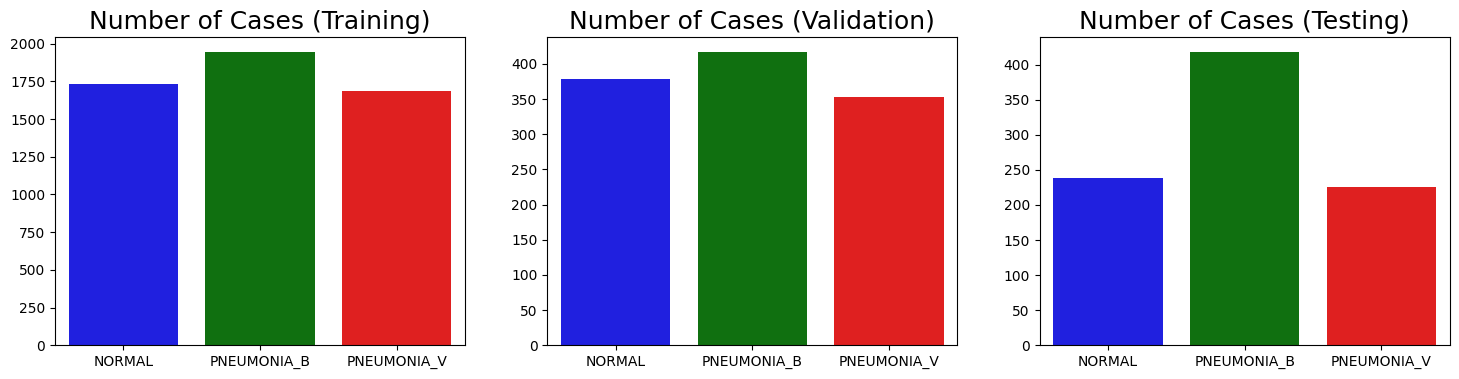

In [7]:
plot_params = get_reset_plot_params()
plot_params['title'] = "Number of Cases"

show_train_val_test_new(dataset_train, validation_dir, testing_dir, plot_params)

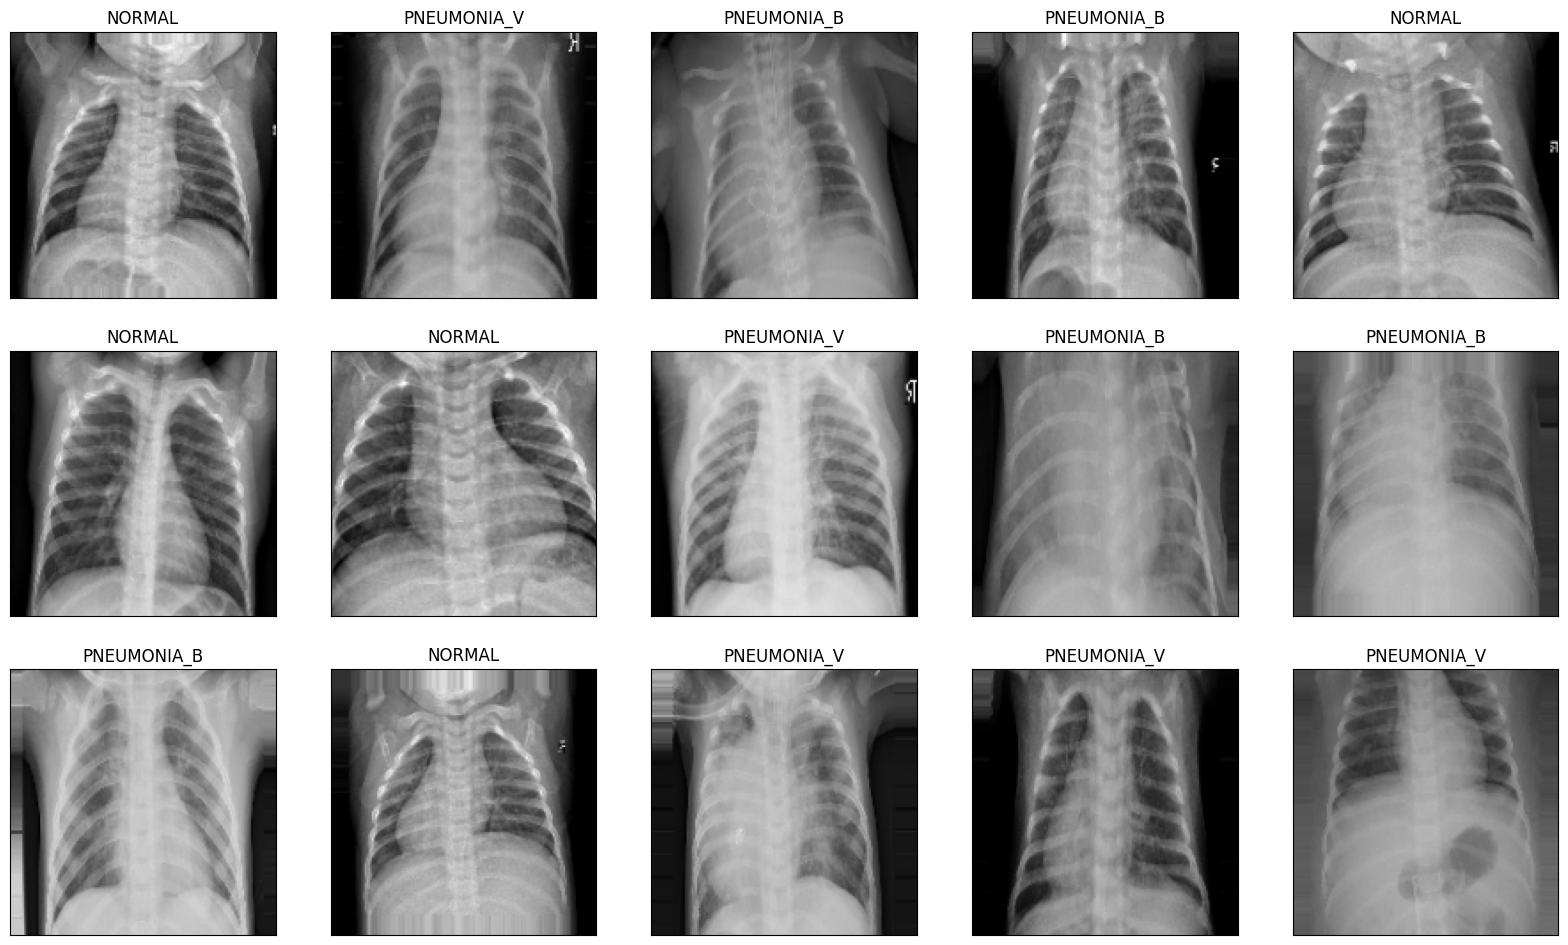

In [8]:
labels = ['NORMAL', 'PNEUMONIA_B', 'PNEUMONIA_V']


def visualize_images(data, labels):
    plt.figure(figsize=(20, 20))
    count = {0: 0, 1: 0, 2: 0}  

    for img, label in data:
        label_idx = np.argmax(label[0])
        if count[label_idx] < 5:
            plt.subplot(5, 5, sum(count.values()) + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(img[0], cmap='gray')
            plt.title(labels[label_idx])
            count[label_idx] += 1
        if sum(count.values()) == 15: 
            break

    plt.show()


visualize_images(train_generator, labels)

## Callback Explication : tensorboard --logdir ```path_model```

- Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    model_dir + "checkpoint_{epoch:02d}.keras", 
    monitor='accuracy', 
    verbose=1,
    save_freq = 'epoch',
)

- Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

- Enable visualizations for TensorBoard.
tensorboard = TensorBoard(
    log_dir=log_dir,
    update_freq = 'epoch',
)

- Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.5,
    patience=4,
    mode='max',
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1
)


## Model 

In [9]:
model = load_model(path_model+'/model.keras')

2024-07-21 18:03:56.019059: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-07-21 18:03:56.019083: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-07-21 18:03:56.019091: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-07-21 18:03:56.019109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-21 18:03:56.019119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 3,739,531 (14.27 MB)

 Trainable params: 1,246,147 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

 Optimizer params: 2,492,296 (9.51 MB)

None


## Insert Test data for evaluate model 

In [11]:
# Loads the weights
model.load_weights(path_model+'/model.keras')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

print(f"Data shape: {test_generator[0][0].shape}")
print(f"Sample labels: {test_generator[0][1][13]}")

# Re-evaluate the model
Loss, Accuracy, AUC = model.evaluate(validation_generator)

Data shape: (881, 150, 150, 3)
Sample labels: [0. 0. 1.]


2024-07-21 18:04:02.736120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/lenaoudjman/.pyenv/versions/3.10.4/envs/zoidberg/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - AUC: 0.9351 - accuracy: 0.7834 - loss: 0.4870


In [12]:
true_labels_test = tf.cast(test_generator[0][1], tf.int32)

predictions = model.predict(test_generator[0][0])
predicted_classes = tf.argmax(predictions, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [13]:
print(true_labels_test.shape)
print(predictions.shape)

predicted_classes = tf.argmax(predictions, axis=1)
print(predicted_classes.shape)

(881, 3)
(881, 3)
(881,)


In [18]:
confusion_matrix = tf.math.confusion_matrix(
    tf.argmax(true_labels_test, axis=1),
    predicted_classes,
    num_classes=3,
)
confusion_matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[230,   2,   6],
       [ 27, 344,  47],
       [ 26,  76, 123]], dtype=int32)>

In [20]:
tp = tf.linalg.diag_part(confusion_matrix)
fp = tf.reduce_sum(confusion_matrix, axis=0) - tp
fn = tf.reduce_sum(confusion_matrix, axis=1) - tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)

f1 = 2 * (precision * recall) / (precision + recall)

print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1-score: [0.88291747 0.81904762 0.61346633]
Precision: [0.81272085 0.81516588 0.69886364]
Recall: [0.96638655 0.82296651 0.54666667]
